# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os
import networkx as nx

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
tfidf_reports = "../../../reports/tfidf/"
reports_comunidades = "../../../reports/analisis_comunidades/"
reports_jaccard = "../../../reports/jaccard_gene_similarity/"

In [4]:
def get_node_dict(G):
    return {node:data for (node,data) in list(G.nodes(data=True))}

def node_labels_to_numeric(G):
    new_labels = {old_label:int(old_label) for old_label in list(G.nodes)}
    nx.relabel_nodes(G,new_labels,False)

In [5]:
graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
G = nx.read_gml(data_processed+"graph_data/gda_network.gml")
node_labels_to_numeric(G)

nodos_gda = pd.DataFrame(get_node_dict(G)).T.reset_index().rename(columns={"index":"node_index"})
nodos_enfermedad = nodos_gda.loc[nodos_gda.node_type == "disease", "node_index"].values

In [8]:
nodos_gda

,node_index,node_type,node_name,node_id,node_source
0,6512,gene_protein,NPBWR1,2831,disgenet
1,27291,disease,"Osteopoikilosis, Isolated",C1833699,disgenet
2,16773,gene_protein,TCAP,8557,disgenet
3,17685,gene_protein,GPR52,9293,disgenet
4,9996,gene_protein,HERC5,51191,disgenet
...,...,...,...,...,...
20851,5377,gene_protein,PANX1,24145,disgenet
20852,22935,disease,Congenital glucose-galactose malabsorption,C0268186,disgenet
20853,782,gene_protein,AGPAT1,10554,disgenet
20854,33412,disease,Spinocerebellar ataxia type 40,C4518336,disgenet


# Jaccard de genes compartidos

In [18]:
def jaccard(set1,set2):
    intersection = len(set1&set2)
    union = len(set1|set2)
    return round(intersection/union,2)

In [15]:
conjuntos_enfermedad = {}

for enfermedad in nodos_enfermedad:
    vecinos = list(G.neighbors(enfermedad))
    conjuntos_enfermedad[enfermedad] = set(vecinos)

In [25]:
matrix_jaccard = np.zeros((len(nodos_enfermedad), len(nodos_enfermedad)))
# indices = np.triu_indices_from(matrix_jaccard, 1)

In [26]:
for i in range(len(nodos_enfermedad)):
    for j in range(len(nodos_enfermedad)):
        nodo_i = nodos_enfermedad[i]
        nodo_j = nodos_enfermedad[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = jaccard(conjunto_i, conjunto_j)
        matrix_jaccard[i,j] = coef

KeyboardInterrupt: 

In [25]:
# for i,j in zip(indices[0],indices[1]):
#     nodo_i = nodos_enfermedad[i]
#     nodo_j = nodos_enfermedad[j]
#     conjunto_i = conjuntos_enfermedad[nodo_i]
#     conjunto_j = conjuntos_enfermedad[nodo_j]
#     coef = jaccard(conjunto_i, conjunto_j)
#     matrix_jaccard[i,j] = coef

In [22]:
sparse_jaccard = sparse.csr_matrix(matrix_jaccard)
# sparse.save_npz(reports_jaccard+"jaccard_sparse_matrix.npz",sparse_jaccard)
df_jaccard_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard, index=nodos_enfermedad, columns=nodos_enfermedad)

In [27]:
df_jaccard_sparse

,22089,28266,24550,26030,27401,23046,25655,18905,23145,21364,...,30676,27493,31056,32954,27399,33566,24225,21370,25670,19722
22089,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
28266,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00
24550,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
26030,0.0,0.00,0.0,0.00,0.03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.02
27401,0.0,0.00,0.0,0.03,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33566,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
24225,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
21370,0.0,0.01,0.0,0.05,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.00
25670,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00


# Similaridad jaccard vs comunidades

## Checkpoint

In [6]:
sparse_jaccard = sparse.load_npz(reports_jaccard+"jaccard_sparse_matrix.npz")
df_jaccard_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard, index=nodos_enfermedad, columns=nodos_enfermedad)

In [7]:
df_jaccard_sparse

,33603,28926,22186,25240,26617,20021,25673,33916,29456,25261,...,28596,34096,28826,28579,21499,29254,20602,28869,28665,25613
33603,1.000000,0.00000,0.000000,0.0,0.0,0.0,0.003795,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.006289,0.0,0.0,0.0
28926,0.000000,1.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.006410,0.0,0.0,0.0
22186,0.000000,0.00000,1.000000,0.0,0.0,0.0,0.007505,0.0,0.0,0.0,...,0.0,0.0,0.083333,0.0,0.0,0.0,0.005988,0.0,0.0,0.0
25240,0.000000,0.00000,0.000000,1.0,0.0,0.0,0.001905,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
26617,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.001873,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29254,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
20602,0.006289,0.00641,0.005988,0.0,0.0,0.0,0.008889,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
28869,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0
28665,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0


In [10]:
graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

tamaños_louvain = disease_attributes.comunidades_louvain.value_counts()
tamaños_infomap = disease_attributes.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

In [9]:
infomap_clusters

,comunidad,tamaño
0,3,198
1,354,82
2,188,74
3,416,74
4,436,71
...,...,...
1136,968,2
1137,1060,2
1138,1010,2
1139,1121,2


Ver cantidad de enlaces GDA por comunidad. Puede ser la fracción de enfermedades con mapeo. Con las dos particiones.

De los que tienen enlaces, ver el numero medio de enlaces. 

Reportar las dos cosas.

In [12]:
mean_similarity_triu(df_jaccard_sparse, 3, "comunidades_infomap")

0.0

In [9]:
def mean_similarity_triu(similarity_matrix, cluster, algoritmo):
    nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
    nodos_disponibles = list(set(nodos_cluster)&set(nodos_enfermedad))
    cluster_matrix = similarity_matrix.loc[nodos_disponibles,nodos_disponibles].values
    indices = np.triu_indices_from(cluster_matrix,1)
    values = cluster_matrix[indices]
    return round(np.mean(values), 2)

In [9]:
infomap_similarity = pd.Series({cluster:mean_similarity_triu(df_jaccard_sparse, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="jaccard_mean_similarity")
louvain_similarity = pd.Series({cluster:mean_similarity_triu(df_jaccard_sparse, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="jaccard_mean_similarity")

infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

Text(0.5, 1.0, 'Louvain')

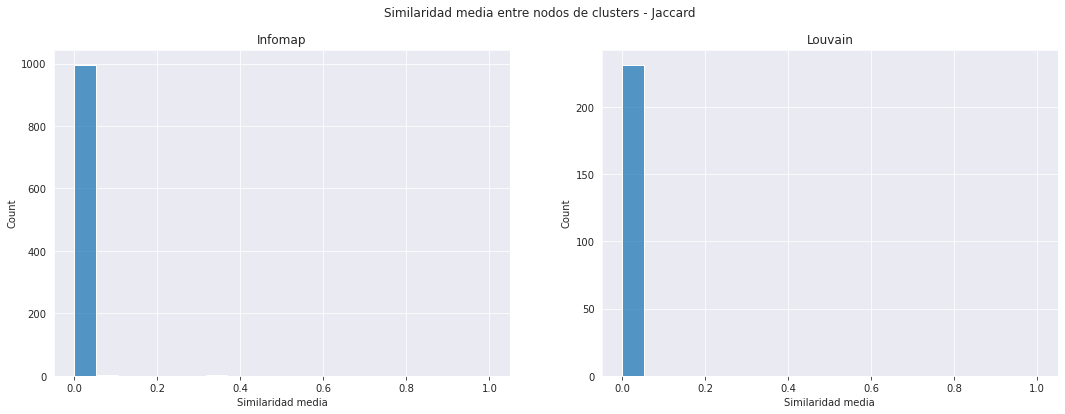

In [12]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Similaridad media entre nodos de clusters - Jaccard")

sns.histplot(data=infomap_clusters["jaccard_mean_similarity"], ax=ax[0], bins=np.linspace(0,1,20))
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters["jaccard_mean_similarity"], ax=ax[1],bins=np.linspace(0,1,20))
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

In [29]:
df_jaccard_sparse

,22089,28266,24550,26030,27401,23046,25655,18905,23145,21364,...,30676,27493,31056,32954,27399,33566,24225,21370,25670,19722
22089,1.000000,0.00000,0.000000,0.0,0.0,0.0,0.003795,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.006289,0.0,0.0,0.0
28266,0.000000,1.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.006410,0.0,0.0,0.0
24550,0.000000,0.00000,1.000000,0.0,0.0,0.0,0.007505,0.0,0.0,0.0,...,0.0,0.0,0.083333,0.0,0.0,0.0,0.005988,0.0,0.0,0.0
26030,0.000000,0.00000,0.000000,1.0,0.0,0.0,0.001905,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
27401,0.000000,0.00000,0.000000,0.0,1.0,0.0,0.001873,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33566,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
24225,0.006289,0.00641,0.005988,0.0,0.0,0.0,0.008889,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
21370,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0
25670,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0


In [13]:
sparse_jaccard

<11167x11167 sparse matrix of type '<class 'numpy.float64'>'
	with 1547443 stored elements in Compressed Sparse Row format>

In [11]:
nonzero_indices = sparse_jaccard.nonzero()